# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {Luitel_Poudel}  
Summer Term 2024  

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Perceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
!pip install torch-summary --no-deps --target=/kaggle/working/
import torchsummary,torchvision
from torch.utils.data import DataLoader
import itertools
from sklearn.metrics import confusion_matrix

torch.manual_seed(42) # Set manual seed

  Using cached torch_summary-1.4.5-py3-none-any.whl.metadata (18 kB)
Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)


In [3]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [4]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [5]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.  

100%|██████████| 170498071/170498071 [00:05<00:00, 28945982.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

 

In [7]:

def show_batch(dl):
    # Get a batch of data
    images, labels = next(iter(dl))
    
    # Normalize the images
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    images = std.reshape(1, 3, 1, 1) * images.numpy() + mean.reshape(1, 3, 1, 1)
    
    # Make a grid from batch manually
    num_images = images.shape[0]
    num_cols = 8  # Adjust the number of images per row
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))
    
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(np.transpose(images[i], (1, 2, 0)))
            ax.set_title(str(labels[i].item()), color='red', fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
show_batch(train_loader)

In [9]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [10]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct/total

In [11]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """

    # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy
    
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    train_loss /= len(dataloader.dataset)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    valid_loss /= len(dataloader.dataset)
    valid_accuracy = 100. * correct / total
    return valid_loss, valid_accuracy
    

In [12]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in trange(num_epochs, desc="Epoch"):
        # Train the model
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, master_bar=None)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate the model
        val_loss, val_acc = validate(val_dataloader, model, loss_function, device, master_bar=None)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs
    

In [13]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """Method to compute the confusion values on the validation set"""
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_targets.extend(targets.tolist())
            all_predictions.extend(predicted.tolist())

    confusion_matrix_values = confusion_matrix(all_targets, all_predictions)
    return confusion_matrix_values


## Logistic Regression   

In [14]:
# TODO: define logistic regression model class and its necessary functions
# What are the dimensions of your input layer?
# TODO: flatten the input to a suitable size for the initial layer

class LogisticRegression(nn.Module):
    def __init__(self, input_size,num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.linear(x)
        return x


In [15]:
## TODO : Define network, put it to the device and train mode
logistic_regression = LogisticRegression(3072,num_classes)
logistic_regression.to(device)

# Set network to train mode
logistic_regression.train()


LogisticRegression(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [16]:
## Optimizer defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [17]:
# TODO: define the loss function
loss_function = nn.CrossEntropyLoss()

In [18]:
num_epochs = 20
## TODO: run training over 20 epochs
train_losses0, val_losses0, train_accs0, val_accs0 = run_training(
    model=logistic_regression,
    optimizer=optimizer,
    loss_function=loss_function,
    device=device,
    num_epochs=num_epochs,
    train_dataloader=train_loader,
    val_dataloader=test_loader
)


Epoch:   5%|▌         | 1/20 [00:16<05:17, 16.73s/it]

Epoch 1/20, Train Loss: 1.9078, Train Acc: 34.84%, Val Loss: 1.8516, Val Acc: 36.60%


Epoch:  10%|█         | 2/20 [00:33<05:01, 16.74s/it]

Epoch 2/20, Train Loss: 1.8344, Train Acc: 37.48%, Val Loss: 1.8769, Val Acc: 37.76%


Epoch:  15%|█▌        | 3/20 [00:50<04:44, 16.72s/it]

Epoch 3/20, Train Loss: 1.8169, Train Acc: 37.97%, Val Loss: 1.8005, Val Acc: 38.52%


Epoch:  20%|██        | 4/20 [01:06<04:27, 16.70s/it]

Epoch 4/20, Train Loss: 1.8009, Train Acc: 38.51%, Val Loss: 1.8708, Val Acc: 37.05%


Epoch:  25%|██▌       | 5/20 [01:23<04:10, 16.70s/it]

Epoch 5/20, Train Loss: 1.7930, Train Acc: 39.04%, Val Loss: 1.7990, Val Acc: 38.84%


Epoch:  30%|███       | 6/20 [01:40<03:53, 16.64s/it]

Epoch 6/20, Train Loss: 1.7969, Train Acc: 38.74%, Val Loss: 1.8050, Val Acc: 38.39%


Epoch:  35%|███▌      | 7/20 [01:56<03:36, 16.65s/it]

Epoch 7/20, Train Loss: 1.7841, Train Acc: 39.29%, Val Loss: 1.8086, Val Acc: 38.81%


Epoch:  40%|████      | 8/20 [02:13<03:19, 16.58s/it]

Epoch 8/20, Train Loss: 1.7751, Train Acc: 39.63%, Val Loss: 1.7899, Val Acc: 38.95%


Epoch:  45%|████▌     | 9/20 [02:29<03:02, 16.57s/it]

Epoch 9/20, Train Loss: 1.7775, Train Acc: 39.46%, Val Loss: 1.8065, Val Acc: 37.40%


Epoch:  50%|█████     | 10/20 [02:46<02:45, 16.55s/it]

Epoch 10/20, Train Loss: 1.7755, Train Acc: 39.28%, Val Loss: 1.8318, Val Acc: 37.11%


Epoch:  55%|█████▌    | 11/20 [03:02<02:28, 16.55s/it]

Epoch 11/20, Train Loss: 1.7748, Train Acc: 39.56%, Val Loss: 1.8254, Val Acc: 36.95%


Epoch:  60%|██████    | 12/20 [03:19<02:12, 16.50s/it]

Epoch 12/20, Train Loss: 1.7761, Train Acc: 39.36%, Val Loss: 1.8328, Val Acc: 37.62%


Epoch:  65%|██████▌   | 13/20 [03:35<01:55, 16.51s/it]

Epoch 13/20, Train Loss: 1.7683, Train Acc: 39.85%, Val Loss: 1.8536, Val Acc: 37.34%


Epoch:  70%|███████   | 14/20 [03:52<01:38, 16.49s/it]

Epoch 14/20, Train Loss: 1.7653, Train Acc: 39.82%, Val Loss: 1.8354, Val Acc: 38.18%


Epoch:  75%|███████▌  | 15/20 [04:08<01:22, 16.49s/it]

Epoch 15/20, Train Loss: 1.7729, Train Acc: 39.74%, Val Loss: 1.8301, Val Acc: 37.29%


Epoch:  80%|████████  | 16/20 [04:24<01:05, 16.44s/it]

Epoch 16/20, Train Loss: 1.7672, Train Acc: 39.97%, Val Loss: 1.8600, Val Acc: 36.18%


Epoch:  85%|████████▌ | 17/20 [04:41<00:49, 16.45s/it]

Epoch 17/20, Train Loss: 1.7588, Train Acc: 40.12%, Val Loss: 1.8062, Val Acc: 39.48%


Epoch:  90%|█████████ | 18/20 [04:57<00:32, 16.45s/it]

Epoch 18/20, Train Loss: 1.7644, Train Acc: 39.67%, Val Loss: 1.8797, Val Acc: 37.51%


Epoch:  95%|█████████▌| 19/20 [05:14<00:16, 16.47s/it]

Epoch 19/20, Train Loss: 1.7610, Train Acc: 40.29%, Val Loss: 1.8029, Val Acc: 39.36%


Epoch: 100%|██████████| 20/20 [05:31<00:00, 16.55s/it]

Epoch 20/20, Train Loss: 1.7615, Train Acc: 39.94%, Val Loss: 1.8451, Val Acc: 38.00%


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [19]:
## TODO: Make the 4 layer MLP  with the following shapes :
## input_dim -> 2048 -> 512 -> 128 -> output_dim
## Use RELu as nonlinearity
## In the forward pass do not forget to flatten the input
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x



In [20]:

## TODO: Define network, put it to device and train mode
mlp=MLP(3072,num_classes)
mlp.to(device)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [21]:
## TODO: Define optimizer and loss functions
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [22]:
## TODO: Train the MLP over 20 epochs

num_epochs = 20

train_losses1, val_losses1, train_accs1, val_accs1 = run_training(
    model=mlp,
    optimizer=optimizer,
    loss_function=loss_function,
    device=device,
    num_epochs=num_epochs,
    train_dataloader=train_loader,
    val_dataloader=test_loader
)


Epoch:   5%|▌         | 1/20 [00:39<12:33, 39.68s/it]

Epoch 1/20, Train Loss: 1.6672, Train Acc: 40.89%, Val Loss: 1.5460, Val Acc: 45.25%


Epoch:  10%|█         | 2/20 [01:19<11:56, 39.83s/it]

Epoch 2/20, Train Loss: 1.4582, Train Acc: 48.42%, Val Loss: 1.4137, Val Acc: 50.67%


Epoch:  15%|█▌        | 3/20 [01:59<11:18, 39.89s/it]

Epoch 3/20, Train Loss: 1.3625, Train Acc: 51.77%, Val Loss: 1.3707, Val Acc: 52.05%


Epoch:  20%|██        | 4/20 [02:40<10:45, 40.32s/it]

Epoch 4/20, Train Loss: 1.2883, Train Acc: 54.42%, Val Loss: 1.3443, Val Acc: 52.39%


Epoch:  25%|██▌       | 5/20 [03:21<10:08, 40.55s/it]

Epoch 5/20, Train Loss: 1.2262, Train Acc: 56.92%, Val Loss: 1.3196, Val Acc: 53.61%


Epoch:  30%|███       | 6/20 [04:02<09:30, 40.75s/it]

Epoch 6/20, Train Loss: 1.1751, Train Acc: 58.54%, Val Loss: 1.3137, Val Acc: 53.94%


Epoch:  35%|███▌      | 7/20 [04:43<08:50, 40.77s/it]

Epoch 7/20, Train Loss: 1.1256, Train Acc: 60.06%, Val Loss: 1.2968, Val Acc: 55.98%


Epoch:  40%|████      | 8/20 [05:24<08:11, 40.93s/it]

Epoch 8/20, Train Loss: 1.0813, Train Acc: 61.66%, Val Loss: 1.3024, Val Acc: 55.24%


Epoch:  45%|████▌     | 9/20 [06:05<07:30, 40.92s/it]

Epoch 9/20, Train Loss: 1.0343, Train Acc: 63.55%, Val Loss: 1.3215, Val Acc: 55.81%


Epoch:  50%|█████     | 10/20 [06:46<06:48, 40.89s/it]

Epoch 10/20, Train Loss: 0.9959, Train Acc: 64.58%, Val Loss: 1.3237, Val Acc: 55.91%


Epoch:  55%|█████▌    | 11/20 [07:27<06:09, 41.04s/it]

Epoch 11/20, Train Loss: 0.9515, Train Acc: 66.05%, Val Loss: 1.3351, Val Acc: 56.03%


Epoch:  60%|██████    | 12/20 [08:08<05:28, 41.01s/it]

Epoch 12/20, Train Loss: 0.9155, Train Acc: 67.37%, Val Loss: 1.3382, Val Acc: 56.64%


Epoch:  65%|██████▌   | 13/20 [08:49<04:47, 41.02s/it]

Epoch 13/20, Train Loss: 0.8668, Train Acc: 68.97%, Val Loss: 1.3403, Val Acc: 56.77%


Epoch:  70%|███████   | 14/20 [09:31<04:06, 41.12s/it]

Epoch 14/20, Train Loss: 0.8362, Train Acc: 70.18%, Val Loss: 1.3980, Val Acc: 56.18%


Epoch:  75%|███████▌  | 15/20 [10:12<03:25, 41.09s/it]

Epoch 15/20, Train Loss: 0.8038, Train Acc: 71.10%, Val Loss: 1.4413, Val Acc: 55.58%


Epoch:  80%|████████  | 16/20 [10:53<02:44, 41.06s/it]

Epoch 16/20, Train Loss: 0.7632, Train Acc: 72.81%, Val Loss: 1.4241, Val Acc: 56.32%


Epoch:  85%|████████▌ | 17/20 [11:34<02:03, 41.04s/it]

Epoch 17/20, Train Loss: 0.7212, Train Acc: 74.10%, Val Loss: 1.4271, Val Acc: 57.31%


Epoch:  90%|█████████ | 18/20 [12:15<01:22, 41.16s/it]

Epoch 18/20, Train Loss: 0.7006, Train Acc: 74.95%, Val Loss: 1.4776, Val Acc: 56.14%


Epoch:  95%|█████████▌| 19/20 [12:56<00:41, 41.18s/it]

Epoch 19/20, Train Loss: 0.6696, Train Acc: 76.14%, Val Loss: 1.5345, Val Acc: 56.46%


Epoch: 100%|██████████| 20/20 [13:37<00:00, 40.89s/it]

Epoch 20/20, Train Loss: 0.6372, Train Acc: 77.39%, Val Loss: 1.5803, Val Acc: 56.44%


## Add L2 regularisation

In [23]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.00005 is a good starting point for the regularization strength
mlp_L2=MLP(3072,num_classes)
mlp_L2.to(device)

optimizer_with_regularization = torch.optim.Adam(mlp_L2.parameters(), lr=0.001, weight_decay=0.00005)

loss_function = nn.CrossEntropyLoss()

In [24]:
## TODO: Retrain new model with regularization over 20 epochs
num_epochs=20
train_losses2, val_losses2, train_accs2, val_accs2 = run_training(
    model=mlp_L2,
    optimizer=optimizer_with_regularization,
    loss_function=loss_function,
    device=device,
    num_epochs=num_epochs,
    train_dataloader=train_loader,
    val_dataloader=test_loader
)

Epoch:   5%|▌         | 1/20 [00:40<12:41, 40.06s/it]

Epoch 1/20, Train Loss: 1.6788, Train Acc: 40.36%, Val Loss: 1.5252, Val Acc: 46.71%


Epoch:  10%|█         | 2/20 [01:19<11:58, 39.94s/it]

Epoch 2/20, Train Loss: 1.4730, Train Acc: 48.04%, Val Loss: 1.4422, Val Acc: 49.18%


Epoch:  15%|█▌        | 3/20 [01:59<11:19, 39.96s/it]

Epoch 3/20, Train Loss: 1.3770, Train Acc: 51.47%, Val Loss: 1.3880, Val Acc: 51.37%


Epoch:  20%|██        | 4/20 [02:39<10:38, 39.94s/it]

Epoch 4/20, Train Loss: 1.3095, Train Acc: 53.88%, Val Loss: 1.3611, Val Acc: 52.45%


Epoch:  25%|██▌       | 5/20 [03:19<10:00, 40.00s/it]

Epoch 5/20, Train Loss: 1.2648, Train Acc: 55.22%, Val Loss: 1.3391, Val Acc: 52.31%


Epoch:  30%|███       | 6/20 [03:59<09:20, 40.02s/it]

Epoch 6/20, Train Loss: 1.2102, Train Acc: 57.32%, Val Loss: 1.3492, Val Acc: 52.50%


Epoch:  35%|███▌      | 7/20 [04:39<08:39, 39.99s/it]

Epoch 7/20, Train Loss: 1.1804, Train Acc: 58.07%, Val Loss: 1.3061, Val Acc: 54.78%


Epoch:  40%|████      | 8/20 [05:19<07:59, 39.98s/it]

Epoch 8/20, Train Loss: 1.1393, Train Acc: 59.58%, Val Loss: 1.3535, Val Acc: 54.15%


Epoch:  45%|████▌     | 9/20 [06:00<07:23, 40.28s/it]

Epoch 9/20, Train Loss: 1.1093, Train Acc: 60.70%, Val Loss: 1.3175, Val Acc: 54.79%


Epoch:  50%|█████     | 10/20 [06:41<06:45, 40.51s/it]

Epoch 10/20, Train Loss: 1.0762, Train Acc: 61.94%, Val Loss: 1.3418, Val Acc: 54.83%


Epoch:  55%|█████▌    | 11/20 [07:23<06:08, 40.89s/it]

Epoch 11/20, Train Loss: 1.0500, Train Acc: 62.61%, Val Loss: 1.2950, Val Acc: 55.73%


Epoch:  60%|██████    | 12/20 [08:06<05:31, 41.43s/it]

Epoch 12/20, Train Loss: 1.0192, Train Acc: 63.98%, Val Loss: 1.3051, Val Acc: 55.25%


Epoch:  65%|██████▌   | 13/20 [08:49<04:52, 41.84s/it]

Epoch 13/20, Train Loss: 0.9896, Train Acc: 64.78%, Val Loss: 1.3223, Val Acc: 55.93%


Epoch:  70%|███████   | 14/20 [09:32<04:14, 42.43s/it]

Epoch 14/20, Train Loss: 0.9671, Train Acc: 65.90%, Val Loss: 1.3001, Val Acc: 56.71%


Epoch:  75%|███████▌  | 15/20 [10:17<03:35, 43.18s/it]

Epoch 15/20, Train Loss: 0.9391, Train Acc: 66.73%, Val Loss: 1.3249, Val Acc: 56.22%


Epoch:  80%|████████  | 16/20 [11:03<02:56, 44.06s/it]

Epoch 16/20, Train Loss: 0.9167, Train Acc: 67.42%, Val Loss: 1.3297, Val Acc: 55.98%


Epoch:  85%|████████▌ | 17/20 [11:51<02:15, 45.12s/it]

Epoch 17/20, Train Loss: 0.8881, Train Acc: 68.47%, Val Loss: 1.3568, Val Acc: 56.21%


Epoch:  90%|█████████ | 18/20 [12:40<01:32, 46.21s/it]

Epoch 18/20, Train Loss: 0.8751, Train Acc: 68.66%, Val Loss: 1.3245, Val Acc: 56.80%


Epoch:  95%|█████████▌| 19/20 [13:30<00:47, 47.43s/it]

Epoch 19/20, Train Loss: 0.8426, Train Acc: 69.94%, Val Loss: 1.3657, Val Acc: 56.37%


Epoch: 100%|██████████| 20/20 [14:21<00:00, 43.06s/it]

Epoch 20/20, Train Loss: 0.8250, Train Acc: 70.40%, Val Loss: 1.4175, Val Acc: 55.47%


## LeNet5

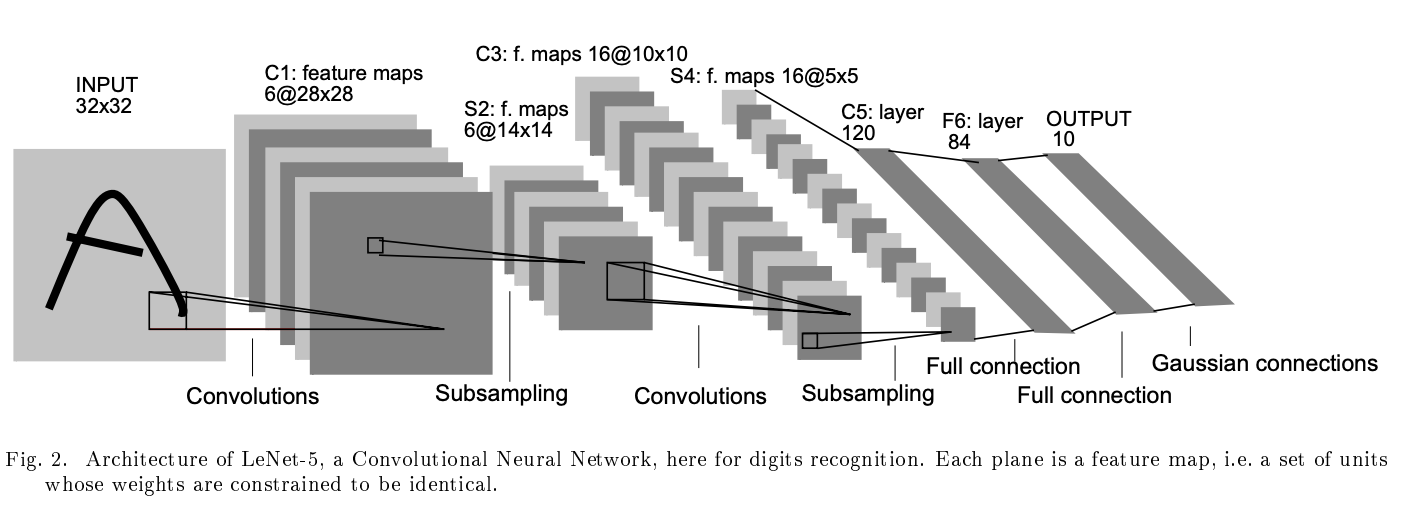

Let's implememt one of the classical convolutional network and apply it for CIFAR-10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implementation of LeNet5 has Tanh as nonlinearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [25]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=3):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()

        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
            nn.ReLU(),
            nn.Linear(in_features=84,out_features=n_classes)
            
    
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [26]:
## TODO: define network, put it to the device and train mode
lenet5=LeNet5(num_classes)
lenet5.to(device)
lenet5.train()


LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

For a quick overview of models, torchsummary.summary is quite helpful  
comment: You can also import predefined architectures from `torchvision` and run `torchsummary.summary` on them to get a quick overview

In [27]:
## TODO: run torchsummary.summary on the LeNet5 and your MLP model. What do you see?
print("                             LeNet5")
torchsummary.summary(lenet5,(3,32,32))
print("                             MLP")
torchsummary.summary(mlp,(3,32,32))


                             LeNet5
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 120, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           456
|    └─ReLU: 2-2                         [-1, 6, 28, 28]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 14, 14]           --
|    └─Conv2d: 2-4                       [-1, 16, 10, 10]          2,416
|    └─ReLU: 2-5                         [-1, 16, 10, 10]          --
|    └─AvgPool2d: 2-6                    [-1, 16, 5, 5]            --
|    └─Conv2d: 2-7                       [-1, 120, 1, 1]           48,120
|    └─ReLU: 2-8                         [-1, 120, 1, 1]           --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Linear: 2-9                       [-1, 84]                  10,164
|    └─ReLU: 2-10                        [-1, 84]                  --
|    └─Linear: 2-11                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 3072]                --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 2048]                6,293,504
|    └─ReLU: 2-2                         [-1, 2048]                --
|    └─Linear: 2-3                       [-1, 512]                 1,049,088
|    └─ReLU: 2-4                         [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 128]                 65,664
|    └─ReLU: 2-6                         [-1, 128]                 --
|    └─Linear: 2-7                       [-1, 10]                  1,290
Total params: 7,409,546
Trainable params: 7,409,546
Non-trainable params: 0
Total mult-adds (M): 14.81
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 28.27
Estimated Total Size (MB): 28.30

In [28]:
## TODO: define loss function and optimizer
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(lenet5.parameters(),lr=0.001)


In [29]:
## TODO: train with 20 epochs
num_epochs = 20
train_losses3, val_losses3, train_accs3, val_accs3 = run_training(
    model=lenet5,
    optimizer=optimizer,
    loss_function=loss_function,
    device=device,
    num_epochs=num_epochs,
    train_dataloader=train_loader,
    val_dataloader=test_loader
)

Epoch:   5%|▌         | 1/20 [00:23<07:18, 23.10s/it]

Epoch 1/20, Train Loss: 1.8386, Train Acc: 33.49%, Val Loss: 1.6409, Val Acc: 41.44%


Epoch:  10%|█         | 2/20 [00:46<06:53, 23.00s/it]

Epoch 2/20, Train Loss: 1.5537, Train Acc: 44.28%, Val Loss: 1.4757, Val Acc: 47.65%


Epoch:  15%|█▌        | 3/20 [01:08<06:30, 22.98s/it]

Epoch 3/20, Train Loss: 1.4457, Train Acc: 48.21%, Val Loss: 1.3955, Val Acc: 50.64%


Epoch:  20%|██        | 4/20 [01:31<06:06, 22.92s/it]

Epoch 4/20, Train Loss: 1.3865, Train Acc: 50.48%, Val Loss: 1.3596, Val Acc: 51.74%


Epoch:  25%|██▌       | 5/20 [01:54<05:43, 22.92s/it]

Epoch 5/20, Train Loss: 1.3388, Train Acc: 51.89%, Val Loss: 1.3162, Val Acc: 52.83%


Epoch:  30%|███       | 6/20 [02:17<05:20, 22.91s/it]

Epoch 6/20, Train Loss: 1.3006, Train Acc: 53.37%, Val Loss: 1.3058, Val Acc: 53.18%


Epoch:  35%|███▌      | 7/20 [02:40<04:57, 22.88s/it]

Epoch 7/20, Train Loss: 1.2628, Train Acc: 54.93%, Val Loss: 1.2758, Val Acc: 54.68%


Epoch:  40%|████      | 8/20 [03:03<04:34, 22.85s/it]

Epoch 8/20, Train Loss: 1.2304, Train Acc: 56.16%, Val Loss: 1.2489, Val Acc: 55.49%


Epoch:  45%|████▌     | 9/20 [03:26<04:11, 22.88s/it]

Epoch 9/20, Train Loss: 1.1954, Train Acc: 57.18%, Val Loss: 1.2131, Val Acc: 56.97%


Epoch:  50%|█████     | 10/20 [03:49<03:48, 22.89s/it]

Epoch 10/20, Train Loss: 1.1625, Train Acc: 58.42%, Val Loss: 1.2121, Val Acc: 57.08%


Epoch:  55%|█████▌    | 11/20 [04:11<03:25, 22.83s/it]

Epoch 11/20, Train Loss: 1.1412, Train Acc: 59.39%, Val Loss: 1.1707, Val Acc: 58.51%


Epoch:  60%|██████    | 12/20 [04:34<03:02, 22.85s/it]

Epoch 12/20, Train Loss: 1.1050, Train Acc: 60.79%, Val Loss: 1.1434, Val Acc: 59.33%


Epoch:  65%|██████▌   | 13/20 [04:57<02:40, 22.86s/it]

Epoch 13/20, Train Loss: 1.0824, Train Acc: 61.56%, Val Loss: 1.1442, Val Acc: 59.31%


Epoch:  70%|███████   | 14/20 [05:20<02:17, 22.91s/it]

Epoch 14/20, Train Loss: 1.0657, Train Acc: 62.15%, Val Loss: 1.1194, Val Acc: 60.11%


Epoch:  75%|███████▌  | 15/20 [05:43<01:54, 22.84s/it]

Epoch 15/20, Train Loss: 1.0442, Train Acc: 63.03%, Val Loss: 1.1057, Val Acc: 60.60%


Epoch:  80%|████████  | 16/20 [06:06<01:31, 22.87s/it]

Epoch 16/20, Train Loss: 1.0269, Train Acc: 63.53%, Val Loss: 1.0916, Val Acc: 61.83%


Epoch:  85%|████████▌ | 17/20 [06:28<01:08, 22.84s/it]

Epoch 17/20, Train Loss: 1.0098, Train Acc: 64.26%, Val Loss: 1.0824, Val Acc: 62.42%


Epoch:  90%|█████████ | 18/20 [06:51<00:45, 22.80s/it]

Epoch 18/20, Train Loss: 0.9946, Train Acc: 64.72%, Val Loss: 1.0732, Val Acc: 62.67%


Epoch:  95%|█████████▌| 19/20 [07:14<00:22, 22.83s/it]

Epoch 19/20, Train Loss: 0.9829, Train Acc: 65.17%, Val Loss: 1.0613, Val Acc: 62.89%


Epoch: 100%|██████████| 20/20 [07:37<00:00, 22.88s/it]

Epoch 20/20, Train Loss: 0.9604, Train Acc: 66.22%, Val Loss: 1.0679, Val Acc: 62.83%


## Analysis 

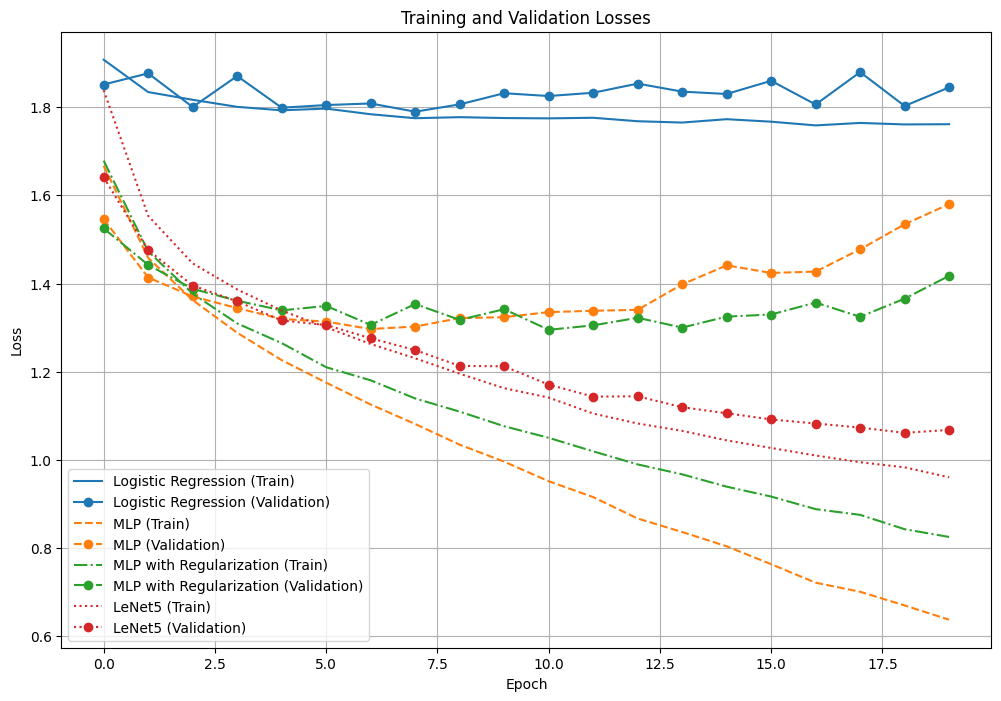

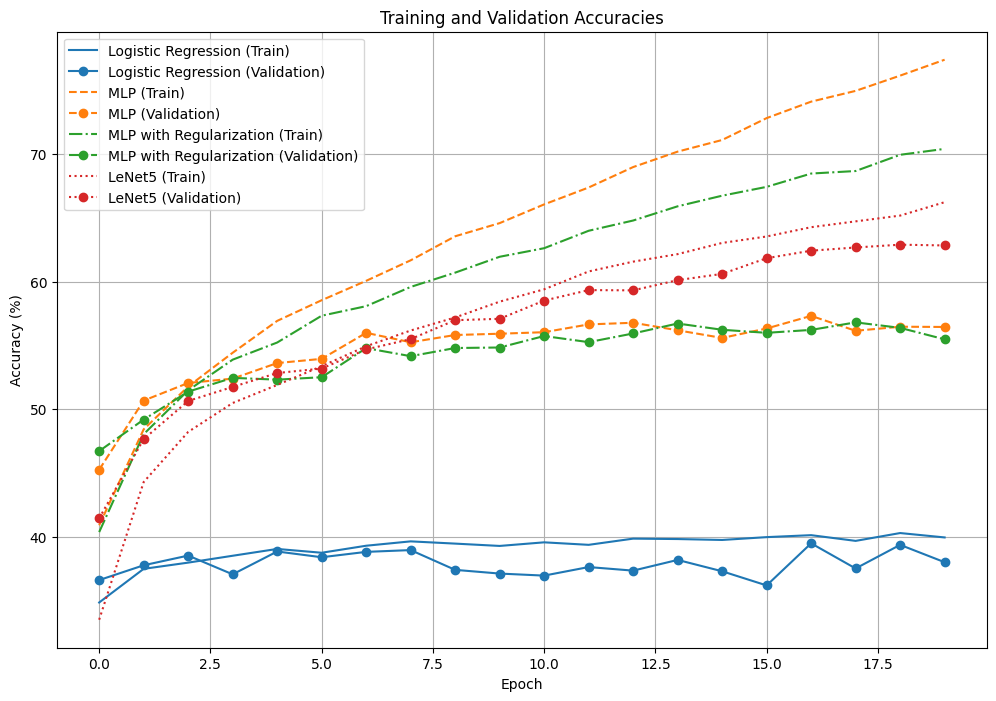

In [30]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

import matplotlib.pyplot as plt


model_names = ["Logistic Regression", "MLP", "MLP with Regularization", "LeNet5"]


train_losses_list = [train_losses0, train_losses1, train_losses2, train_losses3]
val_losses_list = [val_losses0, val_losses1, val_losses2, val_losses3]
train_accs_list = [train_accs0, train_accs1, train_accs2, train_accs3]
val_accs_list = [val_accs0, val_accs1, val_accs2, val_accs3]

plt.figure(figsize=(12, 8))
line_styles = ['-', '--', '-.', ':']
for i in range(len(model_names)):
    plt.plot(train_losses_list[i], label=f"{model_names[i]} (Train)", linestyle=line_styles[i], color='C'+str(i))
    plt.plot(val_losses_list[i], label=f"{model_names[i]} (Validation)", linestyle=line_styles[i], color='C'+str(i), marker='o')

plt.title("Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 8))
for i in range(len(model_names)):
    plt.plot(train_accs_list[i], label=f"{model_names[i]} (Train)", linestyle=line_styles[i], color='C'+str(i))
    plt.plot(val_accs_list[i], label=f"{model_names[i]} (Validation)", linestyle=line_styles[i], color='C'+str(i), marker='o')

plt.title("Training and Validation Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?

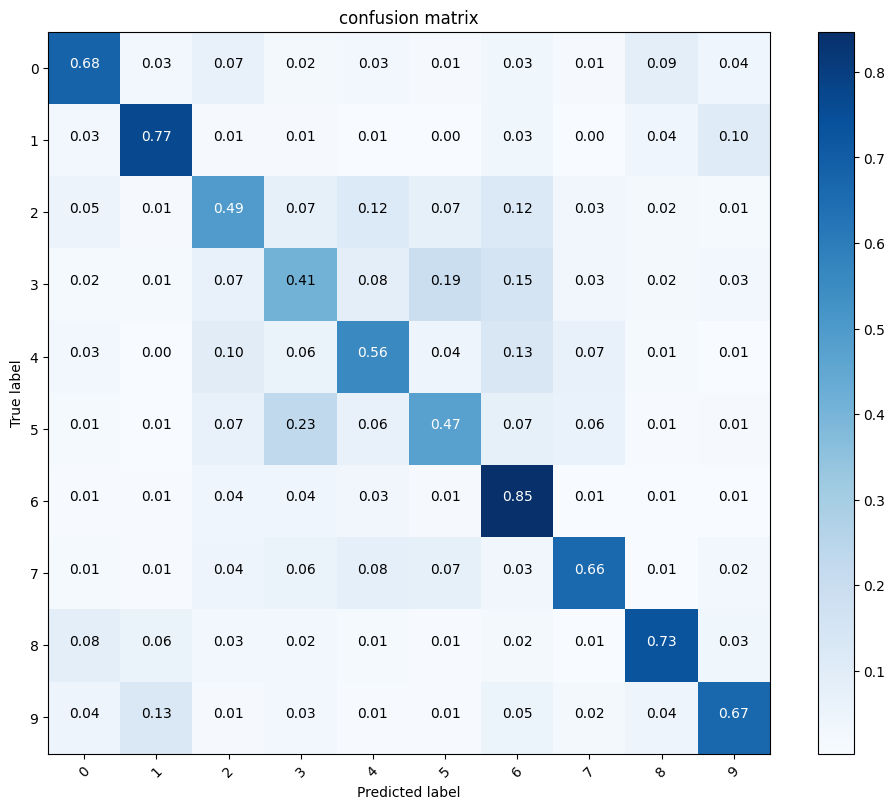

In [46]:
## TODO: Plot the confusion matrix for LeNet5
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf_matrix = calc_confusion_values(test_loader, lenet5, device)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=[str(i) for i in range(10)], normalize=True, title='confusion matrix')

plt.show()
            

## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in performance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
